In [1]:
import numpy as np
import scipy
import daqp
import numpy as np
from ctypes import * 
import ctypes.util
from sympy import Matrix
import matplotlib.pyplot as plt

from generate_mpqp_v2 import generate_qp
from generate_mpqp_v2 import generate_rhs
from self_implement_daqp import daqp_self

import torch
import torch.nn.functional as func
from torch_geometric.data import Data,Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from sklearn.utils.class_weight import compute_class_weight



In [34]:
# Generate general setup
n=2    # number of variables
m=5     # number of constraints
nth = 2
given_seed = 123
np.random.seed(123)
H,f,F,A,b,B = generate_qp(n,m,given_seed)
sense = np.zeros(m, dtype=np.int32)
blower = np.array([-np.inf for i in range(m)])

train_it = 10000
# only change theta
x_train = np.zeros((train_it,n))
lambda_train = np.zeros((train_it,m))
train_iterations = np.zeros((train_it))
# Generate training set
f_train = np.zeros((train_it,n))
b_train = np.zeros((train_it,m))
theta_train = np.zeros((train_it,nth))
for i in range(train_it):
    theta = np.random.randn(nth)
    theta_train[i,:]=theta
    btot = b + B @ theta
    ftot = f + F @ theta
    b_train[i,:]= btot
    f_train[i,:]= ftot
    
    # solve the system for this theta
    x,fval,exitflag,info = daqp.solve(H,ftot,A,btot,blower,sense)
    # print("Optimal solution:")
    # print(x)
    # print("Exit flag:",exitflag)
    # print("Info:",info)
    x_train[i,:]= x
    lambda_train[i,:]= list(info.values())[4]
    train_iterations[i] = list(info.values())[2]

# Generate test set
test_it =2000
x_test = np.zeros((test_it,n))
lambda_test = np.zeros((test_it,m))
test_iterations = np.zeros((test_it))
f_test = np.zeros((test_it,n))
b_test = np.zeros((test_it,m))
for i in range(test_it):
    theta = np.random.randn(2)
    btot = b + B @ theta
    ftot = f + F @ theta
    b_test[i,:]=btot
    f_test[i,:]=ftot
    x,fval,exitflag,info = daqp.solve(H,ftot,A,btot,blower,sense)
    x_test[i,:]= x
    lambda_test[i,:]= list(info.values())[4]
    test_iterations[i] = list(info.values())[2]


In [35]:
# mean of iterations of DAQP
np.mean(train_iterations)

np.float64(2.2268)

In [36]:
# get optimal active set
train_active_set = (lambda_train != 0).astype(int) # this line was written by ChatGPT
y_train = torch.tensor((np.hstack((np.zeros((train_it,n)),train_active_set)))) 
test_active_set = (lambda_test != 0).astype(int)
y_test = torch.tensor((np.hstack((np.zeros((test_it,n)),test_active_set)))) 

In [37]:
# Generate the graph from the training data
graph_train = []
graph_test = []

# generat graph structure does not change, only vertex features
#combine H and A
edge_matrix = np.block([[H,A.T],[A,np.zeros((np.shape(A)[0],np.shape(A)[0]))]])
print("edge matrix shape",edge_matrix.shape)

# create edge_index and edge_attributes
edge_index = torch.tensor([])
edge_attr = torch.tensor([])
for j in range(np.shape(edge_matrix)[0]):
    for k in range(np.shape(edge_matrix)[1]):
        # add edge
        if edge_matrix[j,k] != 0:
            edge_index = torch.cat((edge_index,torch.tensor([[j,k]])),0)
            edge_attr = torch.cat((edge_attr,torch.tensor([edge_matrix[j,k]])),0)
edge_index = edge_index.long().T

# create new vectors filled with zeros to capture vertex features better
f1_train = np.hstack((f_train,np.zeros(np.shape(b_train))))
b1_train = np.hstack((np.zeros(np.shape(f_train)),b_train))
eq1_train = np.hstack((np.zeros(np.shape(f_train)),(np.zeros(np.shape(b_train)))))
print(f1_train.shape,b1_train.shape,eq1_train.shape)

# create matrix with vertex features
x_train = torch.tensor([])
for i in range(train_it):
    x_train = torch.tensor([f1_train[i],b1_train[i], eq1_train[i]]).T
    data_point = Data(x= x_train, edge_index=edge_index, edge_attr=edge_attr,y=y_train[i,:])
    #print(data_point)
    # list of graph elements
    graph_train.append(data_point)

f1_test = np.hstack((f_test,np.zeros(np.shape(b_test))))
b1_test = np.hstack((np.zeros(np.shape(f_test)),b_test))
eq1_test = np.hstack((np.zeros(np.shape(f_test)),(np.zeros(np.shape(b_test)))))
print(f1_test.shape,b1_test.shape,eq1_test.shape)

# test graph
x_test = torch.tensor([])
for i in range(test_it):
    x_test = torch.tensor(np.array([f1_test[i],b1_test[i], eq1_test[i]])).T
    data_point = Data(x= x_test, edge_index=edge_index, edge_attr=edge_attr,y=y_test[i,:])
    # list of graph elements
    graph_test.append(data_point)

edge matrix shape (7, 7)
(10000, 7) (10000, 7) (10000, 7)
(2000, 7) (2000, 7) (2000, 7)


In [6]:
# have a look at the graph data

# batch = Batch.from_data_list(graph_train)
# print(batch.x.shape, batch.edge_index.shape)
# print(batch.y.shape)
# print(batch.x)

In [120]:
import torch.nn.init as init
from sklearn.metrics import mean_squared_error


def WeightedFocalLoss(outputs, targets,alpha = 0.5, gamma = 6):
    alpha_vector = torch.tensor([alpha, 1-alpha])
    BCE_loss = func.binary_cross_entropy_with_logits(outputs, targets, reduction='none')
    targets = targets.type(torch.long)
    at = alpha_vector.gather(0, targets.data.view(-1))
    pt = torch.exp(-BCE_loss)
    F_loss = at*(1-pt)**gamma * BCE_loss
    return F_loss.mean()

def weighted_bce_loss(output, target, fp_weight=3.0, fn_weight=1.0):
    loss = -(
        fn_weight * target * torch.log(output + 1e-8) +  # Penalize FN more
        fp_weight * (1 - target) * torch.log(1 - output + 1e-8)  # Penalize FP more
    )
    return loss.mean()


# Define a simple GNN model for binary classification
class GNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.manual_seed(123)
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, 256)
        self.conv2 = GCNConv(256,128)
        self.conv3 = GCNConv(128,64)
        self.conv4 = GCNConv(64,64)
        self.conv5 = GCNConv(64, output_dim)

        # Xavier initialization for GCN layers
        # init.xavier_uniform_(self.conv1.lin.weight)
        # init.xavier_uniform_(self.hidden.lin.weight)
        # init.xavier_uniform_(self.conv2.lin.weight)
        
    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = func.leaky_relu(self.conv1(x, edge_index),negative_slope = 0.1)
        x = func.leaky_relu(self.conv2(x,edge_index),negative_slope = 0.1)
        x = func.leaky_relu(self.conv3(x,edge_index),negative_slope = 0.1)
        x = func.leaky_relu(self.conv4(x,edge_index),negative_slope = 0.1)
        x = func.leaky_relu(self.conv5(x,edge_index),negative_slope = 0.1)
        return torch.sigmoid(x)  # Sigmoid activation to output probabilities between 0 and 1

# Load Data
loader = DataLoader(graph_train, batch_size=128, shuffle=True)

# Compute class weights for imbalanced classes
all_labels = torch.cat([data.y for data in graph_train])
class_weights = compute_class_weight('balanced', classes=torch.unique(all_labels).numpy(), y=all_labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Instantiate model, loss, and optimizer
model = GNN(input_dim=3, output_dim=1)  # Output dimension is 1 for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




for epoch in range(20):
    epoch_loss = 0
    num_batches = 0
    correct = 0
    total = 0
    save_preds = []
    save_loss = []
    save_acc = []
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = torch.nn.BCELoss(weight=class_weights[batch.y.long()])(output.squeeze(), batch.y.float())
        #loss = WeightedFocalLoss(output.squeeze(), batch.y.float())
        #loss = weighted_bce_loss(output.squeeze(), batch.y.float())


        loss.backward()
        optimizer.step()
        
        # Compute loss
        epoch_loss += loss.item()
        num_batches += 1

        # Compute accuracy
        preds = (output.squeeze() > 0.5).long()  # Convert to binary prediction (0 or 1)
        correct += (preds == batch.y).sum().item()
        total += batch.y.size(0)
        save_preds += preds.tolist()


    avg_loss = epoch_loss / num_batches
    save_loss.append(avg_loss)
    
    acc = correct / total  # Accuracy
    save_acc.append(acc)
    
    #if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {acc}")


Epoch 1, Loss: 0.6852728777293917, Accuracy: 0.6539
Epoch 2, Loss: 0.6650488067276871, Accuracy: 0.6836857142857143
Epoch 3, Loss: 0.6469654282437095, Accuracy: 0.7082285714285714
Epoch 4, Loss: 0.6338012052487724, Accuracy: 0.7225428571428572
Epoch 5, Loss: 0.6196316737162916, Accuracy: 0.7362285714285715
Epoch 6, Loss: 0.6100991911525968, Accuracy: 0.7491428571428571
Epoch 7, Loss: 0.6025641741631906, Accuracy: 0.7569142857142858
Epoch 8, Loss: 0.5839516746846936, Accuracy: 0.7513285714285715
Epoch 9, Loss: 0.5732862640030777, Accuracy: 0.7618714285714285
Epoch 10, Loss: 0.5602645262887206, Accuracy: 0.7701714285714286
Epoch 11, Loss: 0.5501025922690765, Accuracy: 0.7799428571428572
Epoch 12, Loss: 0.5389381209506264, Accuracy: 0.7880428571428572
Epoch 13, Loss: 0.5332615560368646, Accuracy: 0.7928285714285714
Epoch 14, Loss: 0.5286578113519693, Accuracy: 0.7974571428571429
Epoch 15, Loss: 0.5249763576290275, Accuracy: 0.8029857142857143
Epoch 16, Loss: 0.5344913473612145, Accuracy: 

In [113]:
class_weights

tensor([0.6062, 2.8530])

In [117]:
results = torch.cat((output, preds.unsqueeze(1),batch.y.unsqueeze(1)), dim=1)

# Convert to numpy for easy printing
results_np = results.detach().numpy()

print(results_np)

[[0.22778314 0.         0.        ]
 [0.22778314 0.         0.        ]
 [0.43811741 0.         0.        ]
 [0.42095646 0.         0.        ]
 [0.4283621  0.         1.        ]
 [0.48237032 0.         0.        ]
 [0.4645671  0.         0.        ]
 [0.13489859 0.         0.        ]
 [0.13489859 0.         0.        ]
 [0.85271555 1.         0.        ]
 [0.3363049  0.         0.        ]
 [0.85894984 1.         1.        ]
 [0.26686606 0.         0.        ]
 [0.34462994 0.         0.        ]
 [0.33709598 0.         0.        ]
 [0.33709598 0.         0.        ]
 [0.48352948 0.         0.        ]
 [0.43532145 0.         1.        ]
 [0.48211083 0.         0.        ]
 [0.42829946 0.         0.        ]
 [0.43749693 0.         0.        ]
 [0.2310368  0.         0.        ]
 [0.2310368  0.         0.        ]
 [0.60728818 1.         0.        ]
 [0.46754852 0.         1.        ]
 [0.74571246 1.         1.        ]
 [0.38927177 0.         0.        ]
 [0.44833586 0.         0.  

torch.Size([70000])
70000


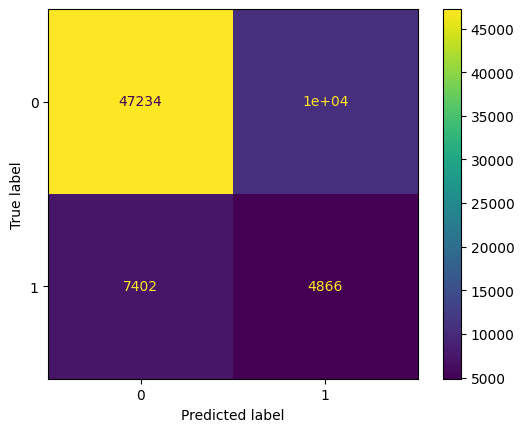

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(all_labels.shape)
print(len(save_preds))
confusion_matrix = confusion_matrix(all_labels, save_preds)
CM = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
CM.plot()


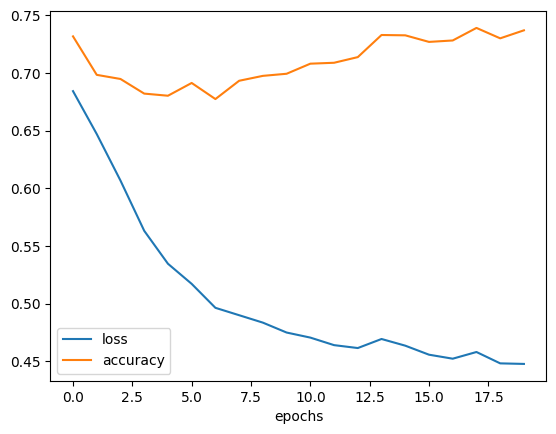

In [ ]:
# vizualize loss & accuracy curve
# 5 variables, 10 constraints
import matplotlib.pyplot as plt

plt.plot(save_loss)
plt.plot(save_acc)
plt.xlabel("epochs")
plt.legend(["loss","accuracy"])

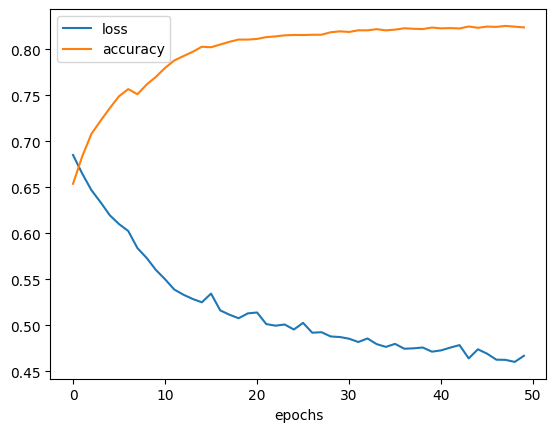

In [45]:
# vizualize loss & accuracy curve
# 2 variables, 5 constraints
import matplotlib.pyplot as plt

plt.plot(save_loss)
plt.plot(save_acc)
plt.xlabel("epochs")
plt.legend(["loss","accuracy"])


In [ ]:
# predict for test data # ChatGPT
# Switch model to evaluation mode
model.eval()

test_loss = 0
num_test_batches = 0

correct = 0
total = 0

test_loader =DataLoader(graph_test,batch_size = test_it,shuffle = True)

with torch.no_grad():  # Disable gradient computation for inference
    for batch in test_loader:
        output = model(batch)  # Forward pass
        #loss = torch.nn.BCELoss(out, batch.y.long())  # Classification
        loss = torch.nn.BCELoss()(output.squeeze(), batch.y.float())

        #loss = func.mse_loss(out, batch.y.float())  # regression

        test_loss += loss.item()  # Accumulate the loss
        num_test_batches += 1
        preds = output.argmax(dim=1)
        correct += (preds == batch.y).sum().item()
        total += batch.y.size(0)
        print(preds.shape)
# Compute average test loss
avg_test_loss = test_loss / num_test_batches
test_acc = correct / total
print(f"Average Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

torch.Size([14000])
Average Test Loss: 0.4861, Test Accuracy: 0.8279


In [ ]:
print(np.sum(preds.tolist()))

0


In [14]:
# time comparison of optimization algorithm with/without ML
model.eval()

time_before = np.zeros(500)
time_after = np.zeros(500)
num_test_batches = 0
for i in range(500):
    theta = np.random.randn(nth)
    btot = b + B @ theta
    ftot = f + F @ theta
    f1 = np.hstack((ftot,np.zeros(np.shape(btot))))
    b1 = np.hstack((np.zeros(np.shape(ftot)),btot))
    eq1 = np.hstack((np.zeros(np.shape(ftot)),(np.zeros(np.shape(btot)))))

    x_input = torch.tensor([f1,b1, eq1]).T
    data_point = Data(x= x_input, edge_index=edge_index, edge_attr=edge_attr)   
    loader_one_datapoint =DataLoader([data_point],batch_size = 1,shuffle = True)

    for batch in loader_one_datapoint:
        out = model(batch)  # Forward pass
        num_test_batches += 1
        preds = out.argmax(dim=1)
        #print(preds)

    A_active = A[preds[n:].bool()]
    b_active = btot[preds[n:].bool()]
    sense_new = np.zeros(len(b_active), dtype=np.int32)
    blower_new = np.array([-np.inf for i in range(len(b_active))])
    #print(H.shape,ftot.shape,A_active.shape,b_active.shape,blower_new.shape,sense_new.shape)

    x,fval,exitflag,info = daqp.solve(H,ftot,A,btot,blower,sense)
    # print("Optimal solution:")
    # print(x)
    # print("Exit flag:",exitflag)
    # print("Info:",info)
    time_before[i]= list(info.values())[0]

    x,fval,exitflag,info = daqp.solve(H,ftot,A_active,b_active,blower,sense)
    # print("Optimal solution:")
    # print(x)
    # print("Exit flag:",exitflag)
    # print("Info:",info)
    time_after[i]= list(info.values())[0]

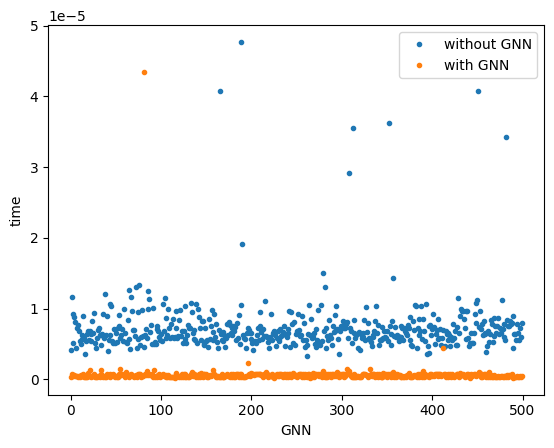

In [ ]:
# vizualize time difference

plt.plot(time_before,'.',)
plt.plot(time_after,'.',)
plt.xlabel("QP")
plt.ylabel("time")
plt.legend(["without GNN","with GNN"])

([<matplotlib.axis.XTick at 0x2812d52f010>,
 [Text(1, 0, 'without GNN'), Text(2, 0, 'with GNN')])

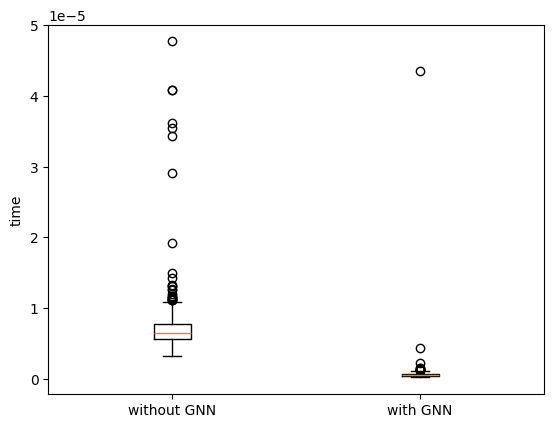

In [16]:
plt.boxplot([time_before,time_after])
plt.ylabel("time")
plt.xticks([1, 2], ['without GNN', 'with GNN'])

In [25]:
## NOW Regression!
import torch.nn.init as init
from sklearn.metrics import mean_squared_error

# Define a simple GNN model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.manual_seed(123)
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, 256)
        self.conv2 = GCNConv(256,128)
        self.conv3 = GCNConv(128,64)
        self.conv4 = GCNConv(64,64)
        self.conv5 = GCNConv(64, output_dim)

        # Xavier initialization for GCN layers
        init.xavier_uniform_(self.conv1.lin.weight)
        init.xavier_uniform_(self.conv2.lin.weight)
        init.xavier_uniform_(self.conv3.lin.weight)
        init.xavier_uniform_(self.conv4.lin.weight)
        init.xavier_uniform_(self.conv5.lin.weight)
        
        
    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x,edge_index))
        x = torch.relu(self.conv3(x,edge_index))
        x = torch.relu(self.conv4(x,edge_index))
        x = self.conv5(x, edge_index)
        return x

# Load Data
loader =DataLoader(graph_train,batch_size = 128,shuffle = True)

#compute weights since the classes are nto evenly distributed
all_labels = torch.cat([data.y for data in graph_train])
class_weights = compute_class_weight('balanced', classes=torch.unique(all_labels).numpy(), y=all_labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)
weights = class_weights[all_labels.long()]

# Instantiate model, loss, and optimizer
model = GNN(input_dim=3, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

save_loss = []
save_mse = []
save_mae = []
save_rmse = []

for epoch in range(20):
    epoch_loss = 0
    num_batches = 0
    total_mse = 0
    total_mae = 0
    total_rmse = 0
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        output = model(batch)
        #loss = torch.nn.MSELoss()(output.squeeze(), batch.y.float())
        loss = torch.nn.L1Loss()(output.squeeze(), batch.y.float())
        mse = mean_squared_error(batch.y.numpy(), output.squeeze().detach().numpy())
        mae = func.l1_loss(output.squeeze(), batch.y.float())
        rmse = torch.sqrt(func.mse_loss(output.squeeze(), batch.y.float()))      
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1

        # Calculate MSE
        total_mse += mse
        total_mae += mae.detach().numpy()
        total_rmse += rmse.detach().numpy()
    
            
    avg_loss = epoch_loss / num_batches
    save_loss.append(avg_loss)
    
    avg_mse = total_mse / num_batches
    save_mse.append(avg_mse)
    
    avg_mae = total_mae / num_batches
    save_mae.append(avg_mae)
    
    avg_rmse = total_rmse / num_batches
    save_rmse.append(avg_rmse)
    
    #if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, MSE: {avg_mse}, MAE : {avg_mae}, RMSE : {avg_rmse}")



Epoch 1, Loss: 0.27104833703252335, MSE: 0.26131695206591393, MAE : 0.27104833722114563, RMSE : 0.5111629962921143
Epoch 2, Loss: 0.27136549051803877, MSE: 0.26162609142906523, MAE : 0.27136552333831787, RMSE : 0.5114750266075134
Epoch 3, Loss: 0.2713807628879064, MSE: 0.26162511249253, MAE : 0.27138078212738037, RMSE : 0.5114731192588806
Epoch 4, Loss: 0.2711483987071846, MSE: 0.2614311257148049, MAE : 0.2711483836174011, RMSE : 0.5112778544425964
Epoch 5, Loss: 0.2713409613204908, MSE: 0.2615735337136413, MAE : 0.2713409662246704, RMSE : 0.5114269256591797
Epoch 6, Loss: 0.2713619342333154, MSE: 0.2615901146693721, MAE : 0.27136197686195374, RMSE : 0.5114443302154541
Epoch 7, Loss: 0.27150759478158587, MSE: 0.2617819483216333, MAE : 0.27150759100914, RMSE : 0.5116260051727295
Epoch 8, Loss: 0.271338987199566, MSE: 0.2615616800396437, MAE : 0.2713389992713928, RMSE : 0.5114114880561829
Epoch 9, Loss: 0.2714448918270159, MSE: 0.2617036333400906, MAE : 0.2714449465274811, RMSE : 0.51155

In [26]:
print(np.sum(preds.tolist()))

0


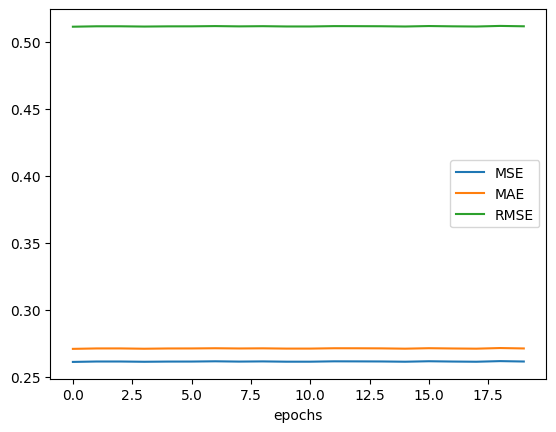

In [27]:
# vizualize loss & accuracy curve
import matplotlib.pyplot as plt

plt.plot(save_mse)
plt.plot(save_mae)
plt.plot(save_rmse)
plt.xlabel("epochs")
plt.legend(["MSE","MAE","RMSE"])

In [ ]:
# # running GNN on simulated data 

# #batch = Batch.from_data_list(graph_train)
# loader = DataLoader(graph_train,batch_size = train_it,shuffle = True)

# # Define a simple GNN
# class GNN(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         torch.manual_seed(1234567)
#         self.conv1 = GCNConv(3, 16) #(num_vertex_features,hidden_channels)
#         self.hidden = GCNConv(16,16)
#         self.conv2 = GCNConv(16, 2) #(hidden_channels,dataset.num_classes) # classification
#         #self.conv2 = GCNConv(16, 1)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.hidden(x,edge_index)
#         x = x.relu()
#         x = func.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x

# # Training loop
# model = GNN()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# save_loss = []
# save_acc = []
# for epoch in range(15):
#     epoch_loss = 0
#     num_batches = 0
#     correct = 0
#     total = 0
#     for batch in loader:
#         optimizer.zero_grad()
#         out = model(batch.x.float(),batch.edge_index)  # classification
#         probabilities = torch.softmax(out, dim=1)        
#         loss = func.cross_entropy(out, batch.y.long())  # classification      
#         preds = out.argmax(dim=1)  # classification
        
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         num_batches += 1
        
#         # Compute accuracy
#         correct += (preds == batch.y).sum().item()
#         total += batch.y.size(0)
        
#     avg_loss = epoch_loss / num_batches
#     save_loss.append(avg_loss)
#     acc = correct / total  # Accuracy
#     save_acc.append(acc)
#     if epoch %50 ==0:
#         print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f},Accuracy: {acc:.4f}")
        
